### Infection des régions avec un ratio trop élevé, puis Regression logistique

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import *
from shapely.wkt import *

# Lecture des fichiers CSV
gdf_csv_path = 'processed_data/swiss_data_all_with_temp_region.csv'
df_presence_csv_path = 'processed_data/df_berce_clean.csv'

# Lecture du GeoDataFrame gdf à partir du CSV
gdf = pd.read_csv(gdf_csv_path)
# Supposons que la géométrie est stockée dans une colonne appelée 'geometry' au format WKT
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.set_crs(epsg=2056, inplace=True)

# Lecture du DataFrame df_presence à partir du CSV
df_presence = pd.read_csv(df_presence_csv_path)

df_presence.describe()

# Supposons que les coordonnées géographiques sont stockées dans les colonnes 'latitude' et 'longitude'
geometry = [Point(xy) for xy in zip(df_presence['decimalLongitude'], df_presence['decimalLatitude'])]
gdf_presence = gpd.GeoDataFrame(df_presence, geometry=geometry, crs="EPSG:4326")

# Étape 2 : Conversion des coordonnées géographiques en LV95
gdf_presence = gdf_presence.to_crs(epsg=2056)

# Étape 3 : Création de la colonne "Presence" dans gdf et initialisation à 0
gdf['Presence'] = 0
gdf['Count'] = 0

# Étape 4 : Comptage des points présents dans chaque zone et incrémentation de la colonne "Presence"
for i, zone in gdf.iterrows(): # TODO : Make it as a func and aply it to gdf !
    # Compter les points de gdf_presence qui sont dans la zone actuelle
    points_in_zone = gdf_presence[gdf_presence.geometry.within(zone.geometry)]
    # Incrémenter la colonne 'Presence' par le nombre de points trouvés
    if len(points_in_zone) > 0 :
        gdf.at[i, 'Presence'] = 1
        gdf.at[i, 'Count'] += len(points_in_zone)

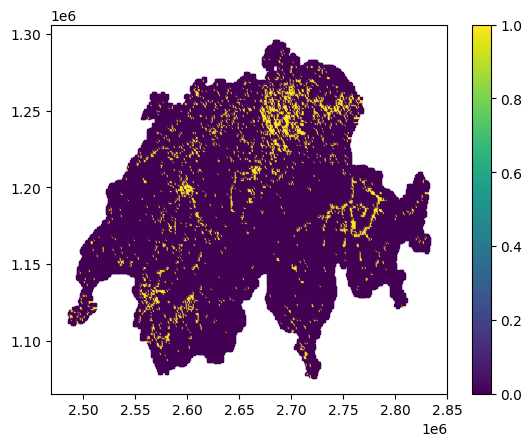

In [3]:
gdf['x'] = None
gdf['y'] = None

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    gdf.at[idx, 'x'] = x[0]
    gdf.at[idx, 'y'] = y[0]

gdf.crs = 'EPSG:2056'

plt.scatter(gdf['x'], gdf['y'], c=gdf['Presence'], cmap='viridis', marker='s', s=2.4)
plt.colorbar()
plt.show()

In [4]:
# Calcul du ratio de présence par région
lambda_threshold = 0.06

stats = gdf.groupby('region').agg(
    nombre_de_zones=('region', 'count'),
    nombre_de_presences=('Presence', 'sum')
).reset_index()

stats['ratio_presences_zones'] = stats['nombre_de_presences'] / stats['nombre_de_zones']
stats['infestee'] = stats['ratio_presences_zones'] > lambda_threshold

stats.sort_values('ratio_presences_zones', ascending=False)

,region,nombre_de_zones,nombre_de_presences,ratio_presences_zones,infestee
3,3,2348,441,0.187819,True
25,25,1030,155,0.150485,True
21,21,758,109,0.143799,True
7,7,2555,363,0.142074,True
16,16,524,74,0.141221,True
4,4,1904,265,0.139181,True
22,22,1050,130,0.123810,True
10,10,2101,257,0.122323,True
12,12,1068,122,0.114232,True
8,8,701,73,0.104137,True


In [5]:
# Fusion des données de présence avec les statistiques
#gdf.drop(columns=['infestee'], inplace=True)
gdf = gdf.merge(stats[['region', 'infestee']], on='region', how='left')
gdf = gdf.merge(stats[['region', 'ratio_presences_zones']], on='region', how='left')

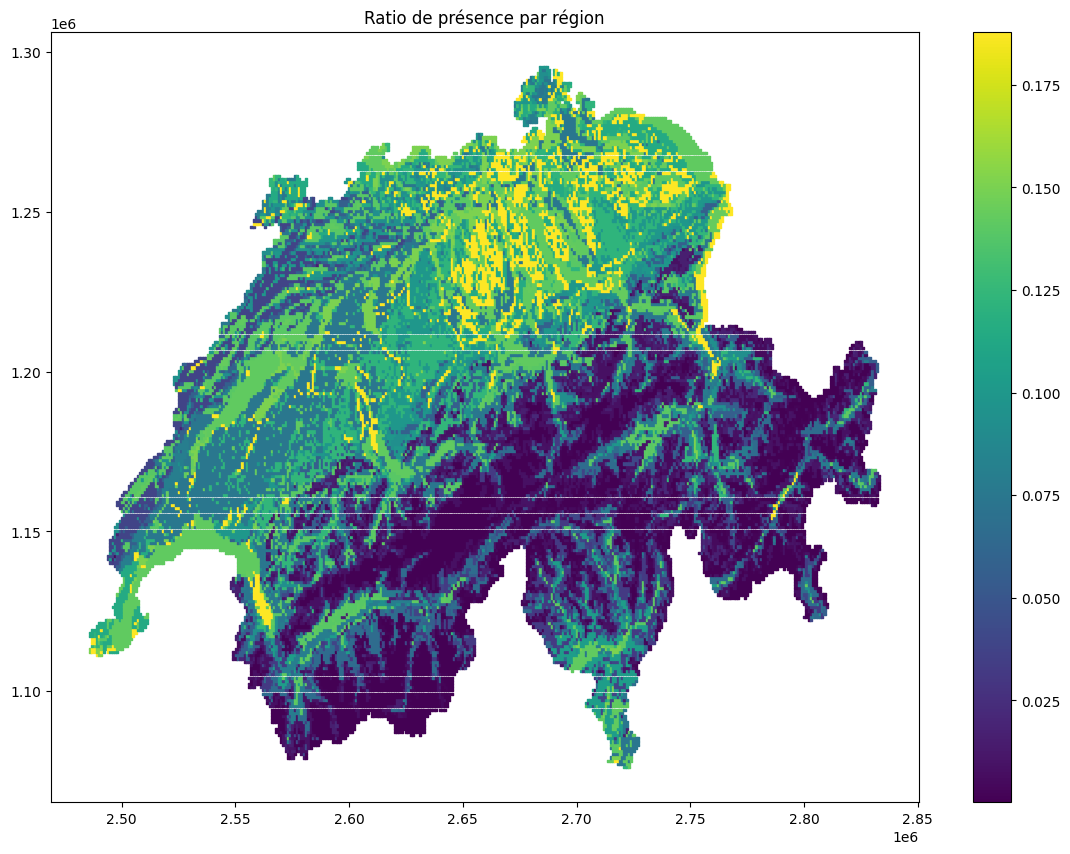

In [6]:
plt.figure(figsize=(14, 10))
plt.scatter(gdf['x'], gdf['y'], c=gdf['ratio_presences_zones'], cmap='viridis', marker='s', s=2.4)
plt.title('Ratio de présence par région')
plt.colorbar()
plt.show()

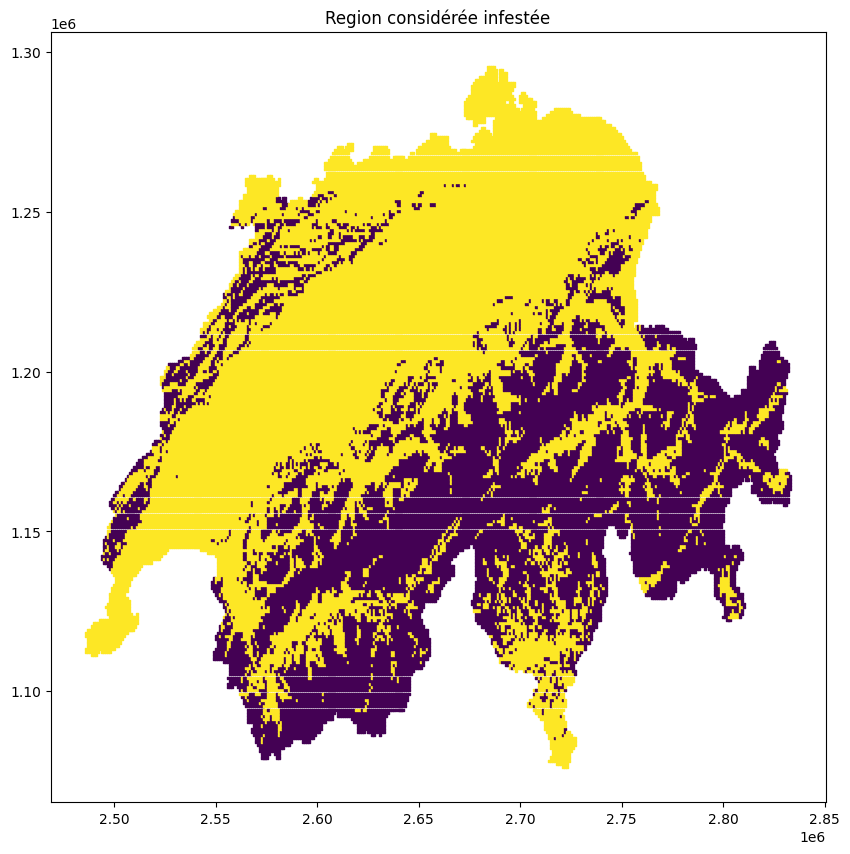

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter(gdf['x'], gdf['y'], c=gdf['infestee'], cmap='viridis', marker='s', s=2.4)
plt.title('Region considérée infestée')
plt.show()

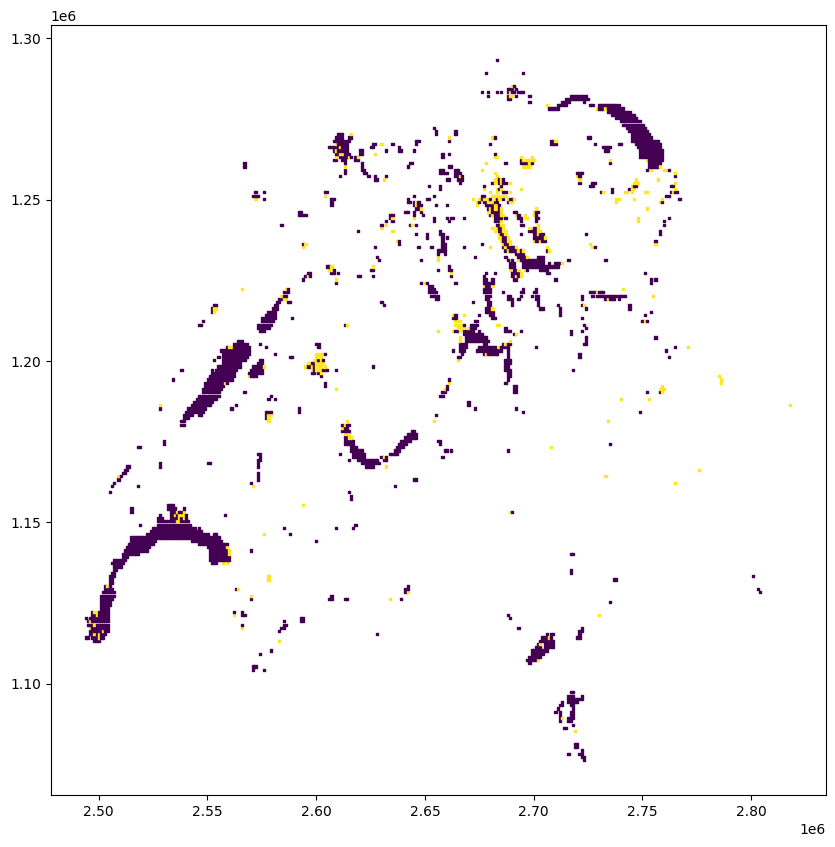

In [8]:
# La région 7 est la région qui contient les différents lacs
# Il est intéressant de voir qu'elle a un ratio de présence très élevé par rapport aux autres régions (ratio de 0.142074) (4ème région la plus infestée)
gdf_region_7 = gdf[gdf['region'] == 7]
plt.figure(figsize=(10, 10))
plt.scatter(gdf_region_7['x'], gdf_region_7['y'], c=gdf_region_7['Presence'], cmap='viridis', marker='s', s=2.4)

# On note que les points infectés sont des bords de grands lacs ou des points qui ont été attribués à la région 7